## Importing libraries and seeding for reproducibility

In [1]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    """
    Ensures reproducibility across Python, NumPy, and PyTorch.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # deterministic results - slightly slower, but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

g = torch.Generator().manual_seed(42) # for data loaders

In [2]:
#importing all the necessary libraries 
import pandas as pd
import seaborn as sns
import numpy as np
import pyreadr as py # library to read .Rdata files in python
import sqlite3
import os
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,Normalizer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize

In [3]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE


### Running on GPU

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data Loading and Preprocessing

### Data Loading

In [5]:
train = pd.read_csv('supervised_train_new.csv')
val = pd.read_csv("supervised_val_new.csv")
test = pd.read_csv("supervised_test_new.csv")

In [6]:
print("Shape of the sampled train data:", train.shape)
print("Shape of the sampled test data:", test.shape)
print("Shape of the sampled CV data:", val.shape)

Shape of the sampled train data: (323200, 57)
Shape of the sampled test data: (434400, 57)
Shape of the sampled CV data: (161600, 57)


In [7]:
train_df_c, val_df_c, test_df_c = train.copy(), val.copy(), test.copy()

In [8]:
features = [col for col in train.columns if 'xmeas' in col or 'xmv' in col]
target = 'faultNumber'

### Scaling

In [9]:
scaler = StandardScaler()
train_df_c[features] = scaler.fit_transform(train_df_c[features])
val_df_c[features] = scaler.transform(val_df_c[features])
test_df_c[features] = scaler.transform(test_df_c[features])

In [10]:
train_df_c

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11,origin,traj_key
0,0.0,362.0,1,-0.038278,-0.254833,0.229698,-0.579412,-0.439815,0.075763,-0.182772,...,0.145188,-0.049192,0.036465,0.745901,-1.073998,-0.168988,-0.063091,-0.333092,fftr,fftr_f0_r362
1,0.0,362.0,2,-0.030522,0.054000,0.122230,-0.140737,1.565026,-0.713069,-0.215499,...,-0.161074,-0.065624,0.010744,0.997497,1.850101,-0.150138,-0.100194,0.199212,fftr,fftr_f0_r362
2,0.0,362.0,3,-0.052021,0.320831,0.151036,-0.238559,-1.913307,-0.566472,-0.166408,...,-0.248784,-0.039131,0.002008,0.478029,-0.937063,-0.163951,-0.155352,-0.578474,fftr,fftr_f0_r362
3,0.0,362.0,4,-0.052527,0.199768,-0.128161,-0.284931,-0.283536,0.438765,-0.151681,...,-0.154476,-0.019234,-0.016239,0.643499,-1.042528,-0.132726,0.026696,0.344035,fftr,fftr_f0_r362
4,0.0,362.0,5,0.080349,-0.672374,0.471226,-0.072701,0.475535,1.035624,-0.217136,...,-0.090584,-0.079932,-0.006339,0.582465,-0.731237,-0.142008,-0.194805,-0.014618,fftr,fftr_f0_r362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323195,20.0,428.0,496,0.151762,0.222004,-0.206823,0.325695,-1.306050,0.323582,-0.271135,...,-0.001425,-0.447253,0.095284,-0.038047,-1.040827,0.371768,-0.146201,0.261182,ftr,ftr_f20_r428
323196,20.0,428.0,497,0.187932,0.165179,-0.544740,0.132759,-0.265675,1.765119,-0.258044,...,-0.147716,-0.474640,0.285329,-0.178765,0.083990,0.384791,-0.142861,0.421213,ftr,ftr_f20_r428
323197,20.0,428.0,498,0.191979,-0.052239,-0.756353,-0.262252,1.596282,-1.020225,-0.241681,...,0.124749,-0.473522,0.293288,-1.936884,0.137573,0.381697,-0.006696,-0.514008,ftr,ftr_f20_r428
323198,20.0,428.0,499,0.063655,-0.385778,0.020301,0.528785,0.212093,-0.395442,-0.189317,...,-0.124702,-0.529302,0.118869,1.724819,-0.054646,0.382129,-0.027473,0.177420,ftr,ftr_f20_r428


### Creating sequences

In [13]:
class SequenceDataset(Dataset):
    def __init__(self, df, features, target, seq_len=30, label_map=None, run_col="seq_id"):
        self.X = []
        self.y = []
        self.seq_len  = seq_len
        self.features = features
        self.target   = target
        self.label_map = label_map
        self.run_col   = run_col

        df = df.sort_values([run_col, "sample"]).reset_index(drop=True)

        for run_id, g in df.groupby(run_col):
            g = g.reset_index(drop=True)
            if len(g) < seq_len:
                continue

            for i in range(len(g) - seq_len + 1):
                seq   = g.iloc[i:i+seq_len][features].values
                label = g.iloc[i+seq_len - 1][target]

                if self.label_map is not None:
                    label = self.label_map[label]

                self.X.append(seq)
                self.y.append(label)

        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.long)
        )


### Extracting labels for testing 

In [14]:
def extract_all_labels(df, features, target, seq_len=30):
    return [int(df.iloc[i+seq_len - 1][target]) for i in range(len(df) - seq_len)]

y_train_raw = extract_all_labels(train_df_c, features, target)
y_val_raw = extract_all_labels(val_df_c, features, target)
y_test_raw = extract_all_labels(test_df_c, features, target)

In [15]:
faults_to_exclude = [3, 9, 15]

unique_labels = sorted(set(y_train_raw) | set(y_val_raw) | set(y_test_raw))
unique_labels = [label for label in unique_labels if label not in faults_to_exclude]

label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}
num_classes = len(label_to_index)


In [16]:
train_dataset = SequenceDataset(train_df_c, features, target, seq_len=30, label_map=label_to_index, run_col="traj_key")
val_dataset = SequenceDataset(val_df_c, features, target, seq_len=30, label_map=label_to_index, run_col="traj_key")
test_dataset = SequenceDataset(test_df_c, features, target, seq_len=30, label_map=label_to_index, run_col="traj_key")

### Data loading in batches

In [17]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,generator = g)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,generator = g)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,generator = g)

## Model Architecture and Training

### Creating the model

In [19]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes,
                 num_heads=4, ff_dim=128, dropout=0.4,
                 max_len=300):
        """
        max_len: maximum sequence length you expect (>= your seq_len, e.g. 30).
        """
        super().__init__()

        # --- Convolutional layers (same as before) ---
        self.conv1 = nn.Conv1d(input_dim, 32, kernel_size=5, padding=2)
        self.bn1   = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2   = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(p=dropout)

        # --- Positional embeddings (NEW) ---
        # d_model = 64 after the CNN
        self.d_model = 64
        self.max_len = max_len
        # shape: (1, max_len, d_model)
        self.pos_emb = nn.Parameter(
            torch.randn(1, max_len, self.d_model)
        )

        # --- Transformer block (same config) ---
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer, num_layers=2
        )

        # --- Pooling and classifier (same) ---
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc1  = nn.Linear(self.d_model, 64)
        self.fc2  = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: (B, L, input_dim)

        # --- CNN feature extraction ---
        x = x.transpose(1, 2)                     # (B, input_dim, L)
        x = F.relu(self.bn1(self.conv1(x)))       # (B, 32, L)
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))       # (B, 64, L)
        x = self.dropout(x)

        # --- Prepare for Transformer ---
        x = x.transpose(1, 2)                     # (B, L, 64)

        B, L, C = x.shape
        # Safety check: L must not exceed max_len
        if L > self.max_len:
            raise ValueError(f"Sequence length {L} > max_len {self.max_len}")

        # --- Add positional embeddings (NEW) ---
        # pos_emb: (1, max_len, C) -> slice to (1, L, C) and broadcast to (B, L, C)
        pos = self.pos_emb[:, :L, :]              # (1, L, 64)
        x = x + pos                               # (B, L, 64)

        # --- Transformer encoder ---
        x = self.transformer(x)                   # (B, L, 64)

        # --- Pooling over time ---
        x = x.transpose(1, 2)                     # (B, 64, L)
        x = self.pool(x).squeeze(-1)              # (B, 64)

        # --- Classifier head ---
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)                        # (B, num_classes)


### Moving model to device

In [20]:
model = TransformerClassifier(
    input_dim=len(features),
    num_classes=num_classes 
).to(device)

### Model Training

In [21]:
def train_classifier(
    model, train_loader, val_loader, criterion, optimizer,
    epochs=50, patience=7, grad_clip=1.0, scheduler_type="cosine"):
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Scheduler
    if scheduler_type == "plateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=3, verbose=True
        )
    elif scheduler_type == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs
        )
    else:
        scheduler = None

    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(epochs):
        # Training 
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()

            if grad_clip:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)

            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == y_val).sum().item()
                total += y_val.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Scheduler step
        if scheduler_type == "plateau":
            scheduler.step(avg_val_loss)
        elif scheduler_type == "cosine":
            scheduler.step()

        # Logging
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | "
              f"LR: {current_lr:.6f}")

        # Early stopping to prevent overfitting
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    #Plot loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('CrossEntropy Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1/50 | Train Loss: 0.7012 | Train Acc: 0.8180 | Val Loss: 0.2035 | Val Acc: 0.9476 | LR: 0.000100
Epoch 2/50 | Train Loss: 0.2104 | Train Acc: 0.9460 | Val Loss: 0.1214 | Val Acc: 0.9717 | LR: 0.000100
Epoch 3/50 | Train Loss: 0.1496 | Train Acc: 0.9672 | Val Loss: 0.1079 | Val Acc: 0.9783 | LR: 0.000099
Epoch 4/50 | Train Loss: 0.1234 | Train Acc: 0.9754 | Val Loss: 0.0980 | Val Acc: 0.9814 | LR: 0.000098
Epoch 5/50 | Train Loss: 0.1100 | Train Acc: 0.9792 | Val Loss: 0.0879 | Val Acc: 0.9843 | LR: 0.000098
Epoch 6/50 | Train Loss: 0.0993 | Train Acc: 0.9815 | Val Loss: 0.1042 | Val Acc: 0.9833 | LR: 0.000096
Epoch 7/50 | Train Loss: 0.0940 | Train Acc: 0.9825 | Val Loss: 0.0897 | Val Acc: 0.9857 | LR: 0.000095
Epoch 8/50 | Train Loss: 0.0878 | Train Acc: 0.9839 | Val Loss: 0.0855 | Val Acc: 0.9877 | LR: 0.000094
Epoch 9/50 | Train Loss: 0.0845 | Train Acc: 0.9848 | Val Loss: 0.0904 | Val Acc: 0.9875 | LR: 0.000092
Epoch 10/50 | Train Loss: 0.0790 | Train Acc: 0.9860 | Val Loss:

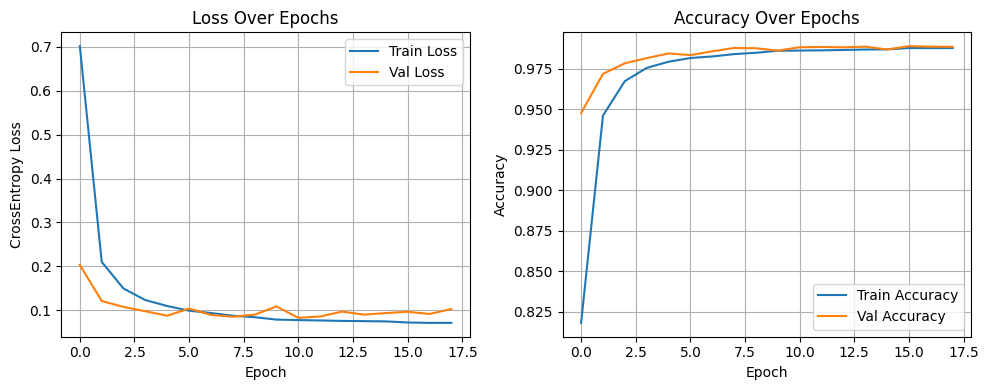

([0.7012061821040017,
  0.2103725410699907,
  0.1496453897686845,
  0.12341109181630207,
  0.10996128319227691,
  0.09931043259641875,
  0.0939938391103456,
  0.08784689027459289,
  0.08445987948284127,
  0.07904762736186652,
  0.0779443053583358,
  0.07706843854408021,
  0.07606700131704142,
  0.07554627653647318,
  0.07497642593142888,
  0.07250211306502037,
  0.07157249704507711,
  0.07168899126522599],
 [0.2034817446510175,
  0.12138306152526425,
  0.10792304522513393,
  0.09798282976446222,
  0.08787354309029972,
  0.10420544541066705,
  0.08968895054863232,
  0.08552970296863112,
  0.09039527594041531,
  0.10894231595042207,
  0.08302195450598313,
  0.08624716726763156,
  0.09722454621400364,
  0.0903936959011155,
  0.09387946932928869,
  0.09684761576007839,
  0.09190728933998207,
  0.10312102181574012],
 [0.8180063145431823,
  0.9459580345984345,
  0.9672301519436953,
  0.9754094586594751,
  0.9792244951654279,
  0.9815102282444255,
  0.9824935867920805,
  0.9839275143063869,
 

In [22]:
criterion = nn.CrossEntropyLoss(label_smoothing=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

train_classifier(
    model, train_loader, val_loader,
    criterion, optimizer,
    epochs=50, patience=7,
    grad_clip=1.0, scheduler_type="cosine"   
)

## Model Evaluation

### Getting all probabilities

In [23]:
all_probs = []
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(y_batch.numpy())

# Concatenate all
all_probs = np.vstack(all_probs)
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

### Label index mapping

In [24]:
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

In [25]:
label_names = [f"Fault {index_to_label[i]}" for i in range(num_classes)]

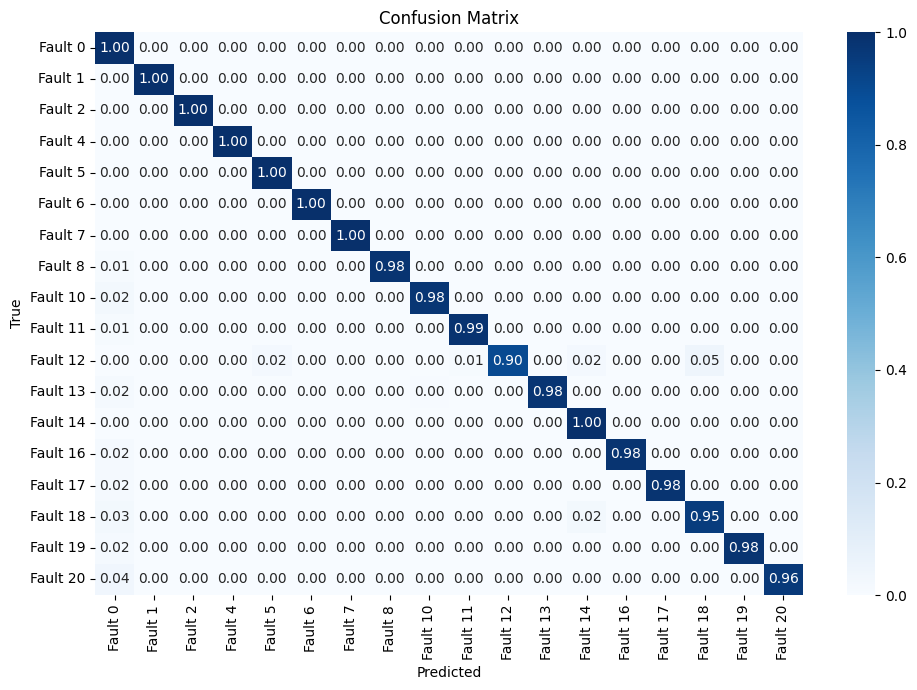

              precision    recall  f1-score   support

     Fault 0    0.99090   1.00000   0.99543    223440
     Fault 1    1.00000   0.99870   0.99935     11565
     Fault 2    0.99810   1.00000   0.99905     11565
     Fault 4    0.99655   1.00000   0.99827     11565
     Fault 5    0.97948   0.99905   0.98917     11565
     Fault 6    1.00000   1.00000   1.00000     11565
     Fault 7    1.00000   1.00000   1.00000     11565
     Fault 8    0.99850   0.98141   0.98988     11565
    Fault 10    0.99444   0.97510   0.98468     11565
    Fault 11    0.99140   0.98668   0.98904     11565
    Fault 12    0.99894   0.90030   0.94706     11565
    Fault 13    0.99656   0.97665   0.98651     11565
    Fault 14    0.95618   1.00000   0.97760     11565
    Fault 16    0.99361   0.98115   0.98734     11565
    Fault 17    1.00000   0.98089   0.99035     11565
    Fault 18    0.95190   0.94968   0.95079     11565
    Fault 19    1.00000   0.98245   0.99115     11565
    Fault 20    1.00000   0

In [26]:
cm = confusion_matrix(all_targets, all_preds, normalize='true')
# print("Confusion Matrix:\n", cm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(all_targets, all_preds, target_names=label_names, digits=5))

### ROC-AUC and PR curves

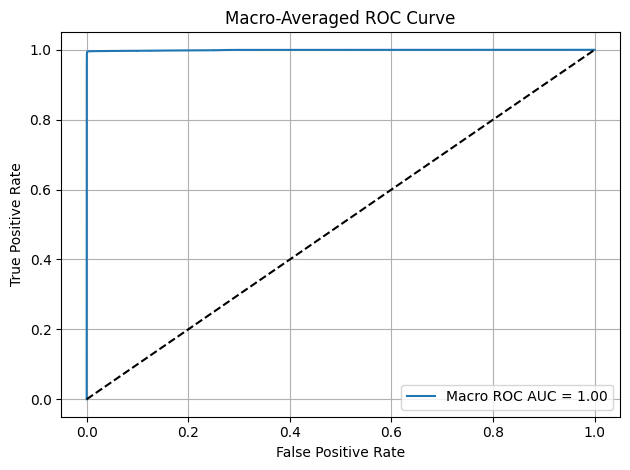

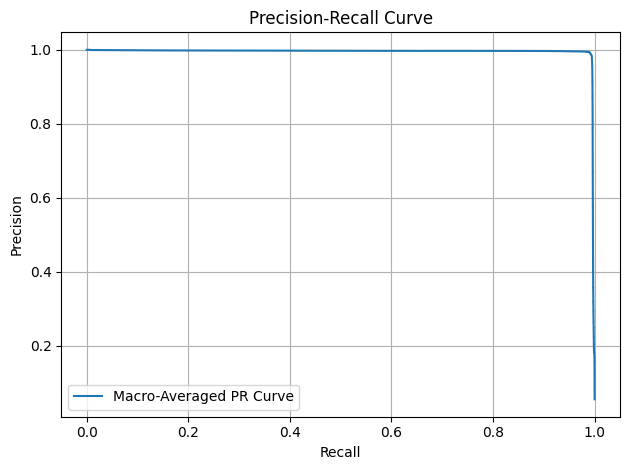

In [27]:
y_true_bin = label_binarize(all_targets, classes=range(num_classes))  # shape: (N, C)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Macro ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-Averaged ROC Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_true_bin.ravel(), all_probs.ravel())
plt.plot(recall, precision, label="Macro-Averaged PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
